# CS733: Module 6 Assignment: Transformer Models for Text Classification and Language Modeling
**Task 1: Setting Up the Transformer Decoder for Language Modeling**

AJ Broderick *(UIN 01244170)* \
abrod006@odu.edu

### Load all needed libraries and packages

*Note:* \
Model created on Wahab cluster at ODU, using Python 3.7 and PyTorch 1.12

In [2]:
%pip -q install seaborn


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
from tqdm.notebook import trange, tqdm

import kagglehub
from sklearn.model_selection  import train_test_split
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model, generate_sp_model

torch.backends.cuda.matmul.allow_tf32 = True

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
%matplotlib inline

### Loading data and prepartion of model
Load file location from Kaggle\
[AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data)

In [6]:
ag_news_path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

ag_train_file = (ag_news_path + '/train.csv')
ag_train_df = pd.read_csv(ag_train_file)
ag_train_df['Description'] = ag_train_df['Description'].map(lambda x: x.lower())
ag_train_df = ag_train_df.rename(columns={"Class Index": "label", "Title": "title", "Description": "text"})

ag_test_file = (ag_news_path + '/test.csv')
ag_test_df = pd.read_csv(ag_test_file)
ag_test_df['Description'] = ag_test_df['Description'].map(lambda x: x.lower())
ag_test_df = ag_test_df.rename(columns={"Class Index": "label", "Title": "title", "Description": "text"})

In [5]:
learning_rate = 1e-4
nepochs = 10
batch_size = 128
max_len = 128

### Create CustomDataset & Apply to data

In [7]:
class CustomDatasetTrain(Dataset):
    def __init__(self, data):
        self.df = pd.read_csv(ag_train_file)
        self.df['Description'] = self.df['Description'].map(lambda x: x.lower())
        self.df = self.df.rename(columns={"Class Index": "label", "Title": "title", "Description": "text"})
        
    def __getitem__(self, idx):
        text = self.df.loc[idx]["text"]
        class_index = int(self.df.loc[idx]["label"]) - 1
        return class_index, text
    
    def __len__(self):
        return len(self.df)
    
class CustomDatasetTest(Dataset):
    def __init__(self, data):
        self.df = pd.read_csv(ag_test_file)
        self.df['Description'] = self.df['Description'].map(lambda x: x.lower())
        self.df = self.df.rename(columns={"Class Index": "label", "Title": "title", "Description": "text"})
        
    def __getitem__(self, idx):
        text = self.df.loc[idx]["text"]
        class_index = int(self.df.loc[idx]["label"]) - 1
        return class_index, text
    
    def __len__(self):
        return len(self.df)

In [8]:
ag_train_data = CustomDatasetTrain(ag_train_df)
ag_test_data = CustomDatasetTest(ag_test_df)

In [9]:
ag_data_loader_train = DataLoader(ag_train_data, batch_size=64, shuffle=True, drop_last=True)
ag_data_loader_test = DataLoader(ag_test_data, batch_size=100)

### Data processing and Tokenization

In [10]:
path = "/home/abrod006/CS733"

with open('ag_data.txt', 'w') as fp:
    pass

ag_train_df['text'].to_csv('ag_train_data.csv')

In [11]:
with open(os.path.join(path, "ag_train_data.csv")) as f:
    with open(os.path.join(path,"ag_data.txt"), 'w') as fp:
        for i, line in enumerate(f):
            text_only = "".join(line.split(",")[1:])
            filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' '))
            filtered = filtered.replace(' #39;', "'")
            filtered = filtered.replace(' #38;', "&")
            filtered = filtered.replace(' #36;', "$")
            filtered = filtered.replace(' #151;', "-")

            fp.write(filtered.lower() + "\n")

In [12]:
generate_sp_model(os.path.join(path,"ag_data.txt"), vocab_size=20000, model_prefix='ag');

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/home/abrod006/CS733/ag_data.txt --model_prefix=ag --vocab_size=20000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/abrod006/CS733/ag_data.txt
  input_format: 
  model_prefix: ag
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>


In [13]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        for line in f:
            yield [line.split("\t")[0]]
vocab = build_vocab_from_iterator(yield_tokens("ag.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'],special_first=True)

vocab.set_default_index(vocab['<unk>'])

In [14]:
text_tranform = T.Sequential(
    T.SentencePieceTokenizer("ag.model"),
    T.VocabTransform(vocab=vocab),
    T.AddToken(1, begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2, begin=False),
    T.ToTensor(padding_value=0),
)

In [15]:
class TokenDrop(nn.Module):
    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        sample_out = (1 - mask) * sample + mask * replace_with
        return sample_out

### Encoder Transformer Network

In [16]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class NanoTransformer(nn.Module):
    def __init__(self, num_emb, output_size, hidden_size=128, num_heads=4):
        super(NanoTransformer, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size),nn.LayerNorm(hidden_size),nn.ELU(),nn.Linear(hidden_size, hidden_size))
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        bs, l = input_seq.shape
        input_embs = self.embedding(input_seq)
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb
        output, attn_map = self.multihead_attn(embs, embs, embs)

        output = self.mlp(output)

        return self.fc_out(output), attn_map

### Start model and Optimizer

In [17]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
hidden_size = 256

tf_classifier = NanoTransformer(num_emb=len(vocab), output_size=4, hidden_size=hidden_size, num_heads=4).to(device)

optimizer = optim.Adam(tf_classifier.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs,eta_min=0)

loss_fn = nn.CrossEntropyLoss()

td = TokenDrop(prob=0.5)

training_loss_logger = []
test_loss_logger = []

training_acc_logger = []
test_acc_logger = []

### Train Model

In [18]:
pbar = trange(0, nepochs, leave=False, desc="Epoch")
train_acc = 0
test_acc = 0

for epoch in pbar:
    train_acc_count = 0
    test_acc_count = 0
    
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%' % (train_acc * 100, test_acc * 100))
    
    tf_classifier.train()
    steps = 0
    
    for label, text in tqdm(ag_data_loader_train, desc="Training", leave=False):
        bs = label.shape[0]
        text_tokens = text_tranform(list(text)).to(device)
        label = label.to(device)

        text_tokens = td(text_tokens)

        pred, _ = tf_classifier(text_tokens)

        loss = loss_fn(pred[:, 0, :], label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_logger.append(loss.item())
        
        train_acc_count += (pred[:, 0, :].argmax(1) == label).sum()
        steps += bs
            
    train_acc = (train_acc_count / steps).item()
    training_acc_logger.append(train_acc)
    
    lr_scheduler.step()
    
    tf_classifier.eval()
    steps = 0
    
    with torch.no_grad():
        for label, text in tqdm(ag_data_loader_test, desc="Testing", leave=False):
            bs = label.shape[0]
            
            text_tokens = text_tranform(list(text)).to(device)
            label = label.to(device)

            pred, _ = tf_classifier(text_tokens)

            loss = loss_fn(pred[:, 0, :], label)
            test_loss_logger.append(loss.item())

            test_acc_count += (pred[:, 0, :].argmax(1) == label).sum()
            steps += bs

        test_acc = (test_acc_count / steps).item()
        test_acc_logger.append(test_acc)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

#### Save model for future use

In [21]:
torch.save(tf_classifier.state_dict(), 'broderick_encoder_model.pth')

In [22]:
vocab = build_vocab_from_iterator(yield_tokens("ag.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)
new_model = NanoTransformer(len(vocab), 4, 256, 4)
new_model.load_state_dict(torch.load('broderick_encoder_model.pth'))
new_model.eval()

NanoTransformer(
  (embedding): Embedding(20003, 256)
  (pos_emb): SinusoidalPosEmb()
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc_out): Linear(in_features=256, out_features=4, bias=True)
)

### Test Model

In [19]:
ag_news_classes = [
    "World",
    "Sports",
    "Business",
    "Science/Technology"
]

with torch.no_grad():
    label, text = next(iter(ag_data_loader_test))
    text_tokens = text_tranform(list(text)).to(device)
    pred, attention_map = tf_classifier(text_tokens)

In [36]:
test_index = 22

att_map = attention_map[test_index, 0]
pred_class = ag_news_classes[pred[test_index, -1].argmax().item()]
top5 = att_map.argsort(descending=True)[:5]
top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())

print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])

Article:
company is expanding production to deliver more flat-panel tvs.

Predicted label:
Science/Technology
True label:
Science/Technology


### Model Metric Plots

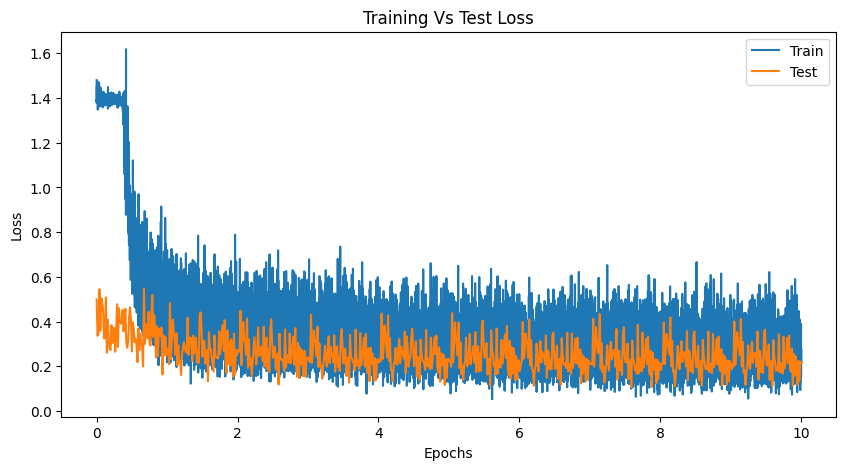

In [23]:
plt.figure(figsize=(10, 5))

plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

plt.legend(["Train", "Test"])
plt.title("Training Vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

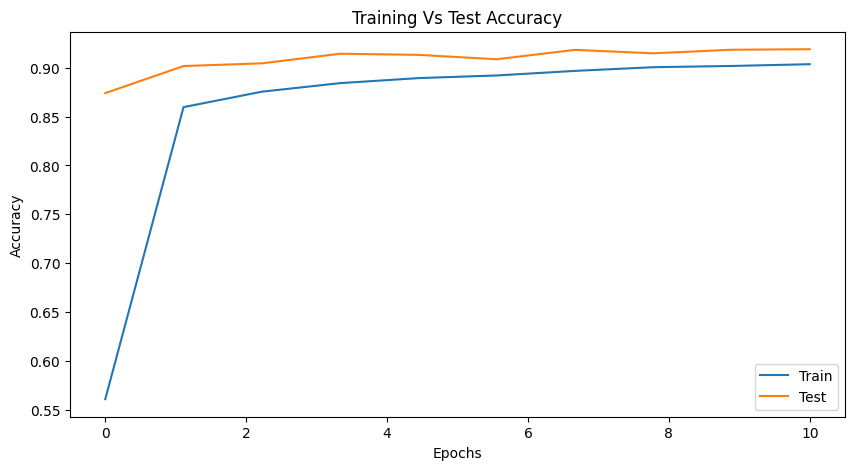

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

plt.legend(["Train", "Test"])
plt.title("Training Vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

### Evaluation Metrics

In [25]:
title = []
actual = []
predictions = []
with torch.no_grad():
    for data in ag_data_loader_test:
        label, text = data
        text_tokens = text_tranform(list(text)).to(device)
        pred, attention_map = tf_classifier(text_tokens)
        for i in range(0,len(label)):
            pred_class = pred[i, -1].argmax().item()
            title.extend([text[i]])
            actual.extend([label[i].item()])
            predictions.extend([pred_class])

In [31]:
print(classification_report(actual, predictions, target_names=ag_news_classes))

                    precision    recall  f1-score   support

             World       0.91      0.82      0.86      1900
            Sports       0.98      0.71      0.82      1900
          Business       0.94      0.62      0.75      1900
Science/Technology       0.57      0.98      0.72      1900

          accuracy                           0.78      7600
         macro avg       0.85      0.78      0.79      7600
      weighted avg       0.85      0.78      0.79      7600



In [32]:
accuracy = accuracy_score(actual, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.780921052631579


In [33]:
precision = precision_score(actual, predictions, average = 'micro')
print("Precision:", precision)

Precision: 0.780921052631579


In [34]:
recall = recall_score(actual, predictions, average = 'micro')
print("Recall:", recall)

Recall: 0.780921052631579


In [35]:
f1 = f1_score(actual, predictions, average = 'micro')
print("F1-score:", f1)

F1-score: 0.780921052631579


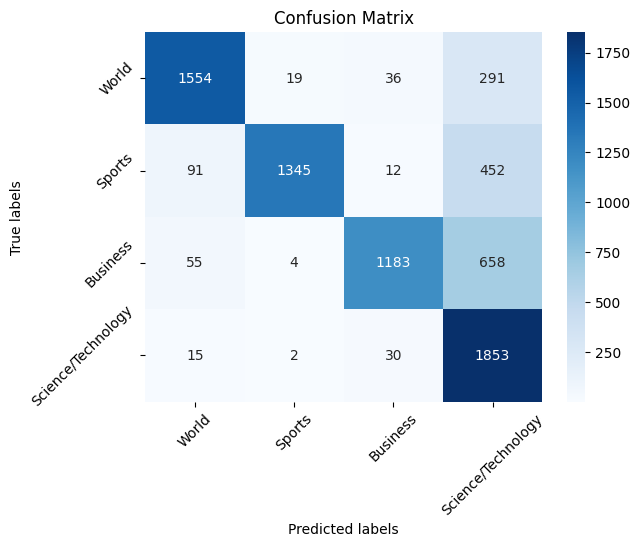

In [29]:
cm = confusion_matrix(actual, predictions)

ax= plt.subplot()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(ag_news_classes); ax.yaxis.set_ticklabels(ag_news_classes);
ax.tick_params(axis='x', labelrotation=45); ax.tick_params(axis='y', labelrotation=45);
plt.show()